In [55]:
#Hello! Gilly here (Illia)

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, make_scorer, cohen_kappa_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier

In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load data.
I put files to ./data

In [58]:
#data = pd.read_csv(r'./data/train.csv')
data = pd.read_csv('/content/drive/MyDrive/IronWeek7_TechChallenge/data/train.csv')

display(data.shape, data['Class'].value_counts(), data.head())

(102, 20)

LIVE    81
DIE     21
Name: Class, dtype: int64

,AGE,SEX,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER BIG,LIVER FIRM,SPLEEN PALPABLE,SPIDERS,ASCITES,VARICES,BILIRUBIN,ALK PHOSPHATE,SGOT,ALBUMIN,PROTIME,HISTOLOGY,Class
0,48,meale,1,2,1,1,2,2,1,2,1,1,1,4.80,123,157,2.7,31,2,DIE
1,51,Male,2,2,1,2,2,2,1,1,1,2,1,1.00,?,20,3.0,63,2,LIVE
2,40,m,1,2,1,2,2,2,1,2,2,2,2,0.60,62,166,4.0,63,1,LIVE
3,25,m,2,2,1,2,2,1,1,1,1,1,1,1.30,181,181,4.5,57,2,LIVE
4,34,M,1,2,1,2,2,1,1,2,1,2,2,1.00,72,46,4.4,57,1,LIVE


In [59]:
data.isnull().sum()/len(data)

AGE                0.0
SEX                0.0
STEROID            0.0
ANTIVIRALS         0.0
FATIGUE            0.0
MALAISE            0.0
ANOREXIA           0.0
LIVER BIG          0.0
LIVER FIRM         0.0
SPLEEN PALPABLE    0.0
SPIDERS            0.0
ASCITES            0.0
VARICES            0.0
BILIRUBIN          0.0
ALK PHOSPHATE      0.0
SGOT               0.0
ALBUMIN            0.0
PROTIME            0.0
HISTOLOGY          0.0
Class              0.0
dtype: float64

In [60]:
numericals = data.select_dtypes(np.number)
numericals.head()

,AGE,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,HISTOLOGY
0,48,2,1,1,2,2
1,51,2,1,2,2,2
2,40,2,1,2,2,1
3,25,2,1,2,2,2
4,34,2,1,2,2,1


In [61]:
numericals.describe

<bound method NDFrame.describe of      AGE  ANTIVIRALS  FATIGUE  MALAISE  ANOREXIA  HISTOLOGY
0     48           2        1        1         2          2
1     51           2        1        2         2          2
2     40           2        1        2         2          1
3     25           2        1        2         2          2
4     34           2        1        2         2          1
..   ...         ...      ...      ...       ...        ...
97    23           2        1        1         1          1
98    38           2        2        2         2          2
99    36           2        2        2         2          1
100   32           1        1        1         2          1
101   54           1        2        2         2          2

[102 rows x 6 columns]>

### Cleaning

In [62]:
df=data.copy()
df['SEX'] = df['SEX'].apply(lambda x: 'F' if 'f' in x.lower() else 'M')
df['SEX'].value_counts()

M    92
F    10
Name: SEX, dtype: int64

In [63]:
# Replace value 'c' in column 'col' with the mean of column 'col'.
def replace_by_median(data, col, c):
    data[col].mask(data[col] == c, 0, inplace=True)
    data[col] = pd.to_numeric(data[col])
    data[col].mask(data[col] == 0, data[col].median(), inplace=True)

def clean_categorical_columns(data):
    for col in data.columns:
        if pd.api.types.is_categorical_dtype(data[col]):
            unique_values = data[col].unique()
            for value in unique_values:
                if pd.notna(value):
                    replace_by_mean(data, col, value)
    return data

In [64]:
def replace_question_marks_with_median(data):
    for col in data.columns:
        # Check if the column contains question marks
        if data[col].dtype == object and data[col].str.contains('\?').any():
            # Replace question marks with NaN
            data[col] = data[col].replace('?', np.nan)
            # Convert the column to a numeric type
            data[col] = pd.to_numeric(data[col])
            # Calculate the median of the column
            median = data[col].median()
            # Replace NaN values with the median
            data[col].fillna(median, inplace=True)
    return data

In [65]:
#clean it
df=clean_categorical_columns(df)
display(df.head(),df['SEX'].value_counts())

,AGE,SEX,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER BIG,LIVER FIRM,SPLEEN PALPABLE,SPIDERS,ASCITES,VARICES,BILIRUBIN,ALK PHOSPHATE,SGOT,ALBUMIN,PROTIME,HISTOLOGY,Class
0,48,M,1,2,1,1,2,2,1,2,1,1,1,4.80,123,157,2.7,31,2,DIE
1,51,M,2,2,1,2,2,2,1,1,1,2,1,1.00,?,20,3.0,63,2,LIVE
2,40,M,1,2,1,2,2,2,1,2,2,2,2,0.60,62,166,4.0,63,1,LIVE
3,25,M,2,2,1,2,2,1,1,1,1,1,1,1.30,181,181,4.5,57,2,LIVE
4,34,M,1,2,1,2,2,1,1,2,1,2,2,1.00,72,46,4.4,57,1,LIVE


M    92
F    10
Name: SEX, dtype: int64

In [66]:
df=replace_question_marks_with_median(df)
display(df.head(),df['SEX'].value_counts())

,AGE,SEX,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER BIG,LIVER FIRM,SPLEEN PALPABLE,SPIDERS,ASCITES,VARICES,BILIRUBIN,ALK PHOSPHATE,SGOT,ALBUMIN,PROTIME,HISTOLOGY,Class
0,48,M,1.0,2,1,1,2,2.0,1.0,2.0,1.0,1.0,1.0,4.8,123.0,157.0,2.7,31.0,2,DIE
1,51,M,2.0,2,1,2,2,2.0,1.0,1.0,1.0,2.0,1.0,1.0,85.0,20.0,3.0,63.0,2,LIVE
2,40,M,1.0,2,1,2,2,2.0,1.0,2.0,2.0,2.0,2.0,0.6,62.0,166.0,4.0,63.0,1,LIVE
3,25,M,2.0,2,1,2,2,1.0,1.0,1.0,1.0,1.0,1.0,1.3,181.0,181.0,4.5,57.0,2,LIVE
4,34,M,1.0,2,1,2,2,1.0,1.0,2.0,1.0,2.0,2.0,1.0,72.0,46.0,4.4,57.0,1,LIVE


M    92
F    10
Name: SEX, dtype: int64

now it is *clean*

# **Upsampling**

In [67]:
# Upsampling (Get rid of imbalance in column 'Class' [DIE < LIVE])
die  = df[df['Class']=='DIE']
live = df[df['Class']=='LIVE']

die2 = resample(die, replace = True, n_samples = len(live))

df = pd.concat([die2, live])
df['Class'].value_counts()

DIE     81
LIVE    81
Name: Class, dtype: int64

# **X/y Split**

In [68]:
# Do the X/y split to seperate dependent from independent columns
X = df.drop('Class', axis=1)
y = df['Class']

# **Encode categoricals**

In [69]:
# Encode categorical columns to numerical (There's only one!)
X = pd.get_dummies(X, drop_first=True)

# **Train/Test split**

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **Apply StandardScaler**

In [71]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X.columns)
X_test_scaled  = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

with open('standard_scaler.pickle', 'wb') as file:
    pickle.dump(scaler, file)

**Perform a GridSearch for RandomForestClassifier**

In [72]:
params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'min_samples_leaf': [2,4],
    'min_samples_split': [2,4]
}

In [73]:
gs = GridSearchCV(estimator=RandomForestClassifier(),
                  param_grid=params, cv=5)
gs.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'min_samples_leaf': [2, 4],
                         'min_samples_split': [2, 4]})

In [74]:
gs.best_params_

{'criterion': 'log_loss', 'min_samples_leaf': 2, 'min_samples_split': 2}

In [75]:
y_train_pred = gs.predict(X_train_scaled)
y_test_pred  = gs.predict(X_test_scaled)
cohen_kappa_score(y_test, y_test_pred)

0.8170055452865065

In [76]:
with open('random_forest.pickle', 'wb') as file:
    pickle.dump(gs.best_estimator_, file)


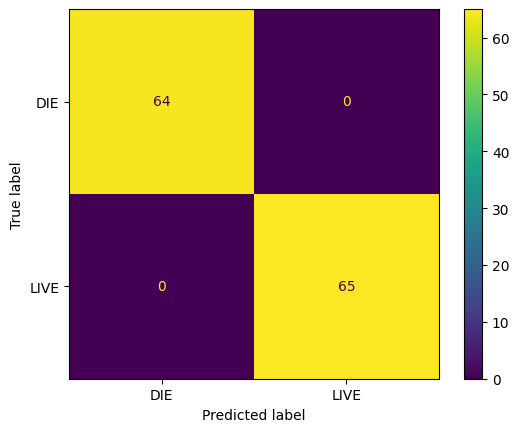

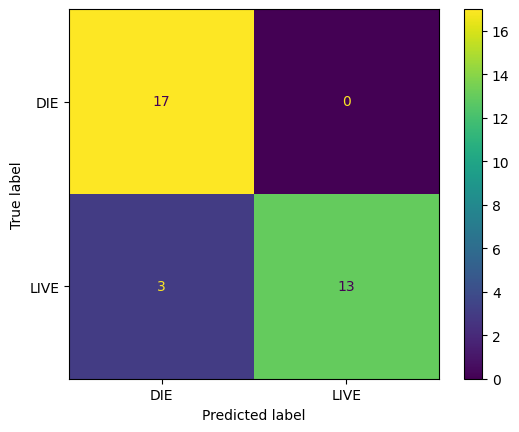

In [77]:
# Plot confusion matrix for train set prediction
cm_train = confusion_matrix(y_train, y_train_pred)
ConfusionMatrixDisplay(cm_train, display_labels=gs.best_estimator_.classes_).plot()
plt.show()

# Plot confusion matrix for test set prediction
cm_test = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(cm_test, display_labels=gs.best_estimator_.classes_).plot()
plt.show()

In [78]:
results = cross_val_score(gs.best_estimator_, X_train_scaled, y_train, cv=5)
print(f"Average accuracy: {results.mean()}")
results = cross_val_score(gs.best_estimator_, X_test_scaled, y_test, cv=5)
print(f"Average accuracy: {results.mean()}")

Average accuracy: 0.9384615384615385
Average accuracy: 0.7857142857142857


# **Perform a GridSearch for LogisticRegression**

In [79]:
params = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['saga'],  # 'saga' supports 'l1' penalty
    'max_iter': [300]
}


gs = GridSearchCV(estimator=LogisticRegression(), param_grid=params, cv=5)
gs.fit(X_train_scaled, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behav

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'max_iter': [300],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['saga']})

# **Perform a GridSearch for KNN-Classifier**

In [80]:
params = {
    'n_neighbors': [3, 5, 8, 10],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

gs = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=params, cv=5, verbose=3)
gs.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END algorithm=auto, n_neighbors=3, weights=uniform;, score=1.000 total time=   0.0s
[CV 2/5] END algorithm=auto, n_neighbors=3, weights=uniform;, score=0.923 total time=   0.0s
[CV 3/5] END algorithm=auto, n_neighbors=3, weights=uniform;, score=1.000 total time=   0.0s
[CV 4/5] END algorithm=auto, n_neighbors=3, weights=uniform;, score=0.885 total time=   0.0s
[CV 5/5] END algorithm=auto, n_neighbors=3, weights=uniform;, score=0.960 total time=   0.0s
[CV 1/5] END algorithm=auto, n_neighbors=3, weights=distance;, score=1.000 total time=   0.0s
[CV 2/5] END algorithm=auto, n_neighbors=3, weights=distance;, score=0.923 total time=   0.0s
[CV 3/5] END algorithm=auto, n_neighbors=3, weights=distance;, score=1.000 total time=   0.0s
[CV 4/5] END algorithm=auto, n_neighbors=3, weights=distance;, score=0.885 total time=   0.0s
[CV 5/5] END algorithm=auto, n_neighbors=3, weights=distance;, score=0.960 total time=   0.0s
[CV

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [3, 5, 8, 10],
                         'weights': ['uniform', 'distance']},
             verbose=3)

In [81]:
y_train_pred = gs.predict(X_train_scaled)
y_test_pred  = gs.predict(X_test_scaled)
cohen_kappa_score(y_test, y_test_pred)

0.574585635359116

In [82]:
results = cross_val_score(gs.best_estimator_, X_train_scaled, y_train, cv=5)
print(f"Average accuracy: {results.mean()}")
results = cross_val_score(gs.best_estimator_, X_test_scaled, y_test, cv=5)
print(f"Average accuracy: {results.mean()}")

Average accuracy: 0.9535384615384614
Average accuracy: 0.7857142857142857


In [83]:
with open('knn.pickle', 'wb') as file:
    pickle.dump(gs.best_estimator_, file)

###Decision Tree Model

In [86]:
# Create A Dot Plot
from sklearn.tree import DecisionTreeClassifier
from IPython.display import Image
from sklearn import tree
import pydotplus
import graphviz

NameError: ignored

In [87]:
dcf = DecisionTreeClassifier(random_state=0)
dcf.fit(X_train_scaled,y_train_pred)


DecisionTreeClassifier(random_state=0)

In [89]:
dcf.score(X_test_scaled,y_test_pred)

0.8787878787878788

In [90]:
feature_names = [
    'AGE', 'SEX', 'STEROID', 'ANTIVIRALS', 'FATIGUE', 'MALAISE',
    'ANOREXIA', 'LIVER_BIG', 'LIVER_FIRM', 'SPLEEN_PALPABLE', 'SPIDERS',
    'ASCITES', 'VARICES', 'BILIRUBIN', 'ALK_PHOSPHATE', 'SGOT', 'ALBUMIN',
    'PROTIME', 'HISTOLOGY'
]

target_names = ["DIE", "LIVE"]

In [97]:
with open('dtree.pickle', 'wb') as file:
    pickle.dump(dcf, file)

In [92]:
dot_data = tree.export_graphviz(dcf, out_file=None, feature_names=feature_names, class_names=target_names)

In [93]:
graph = pydotplus.graph_from_dot_data(dot_data)

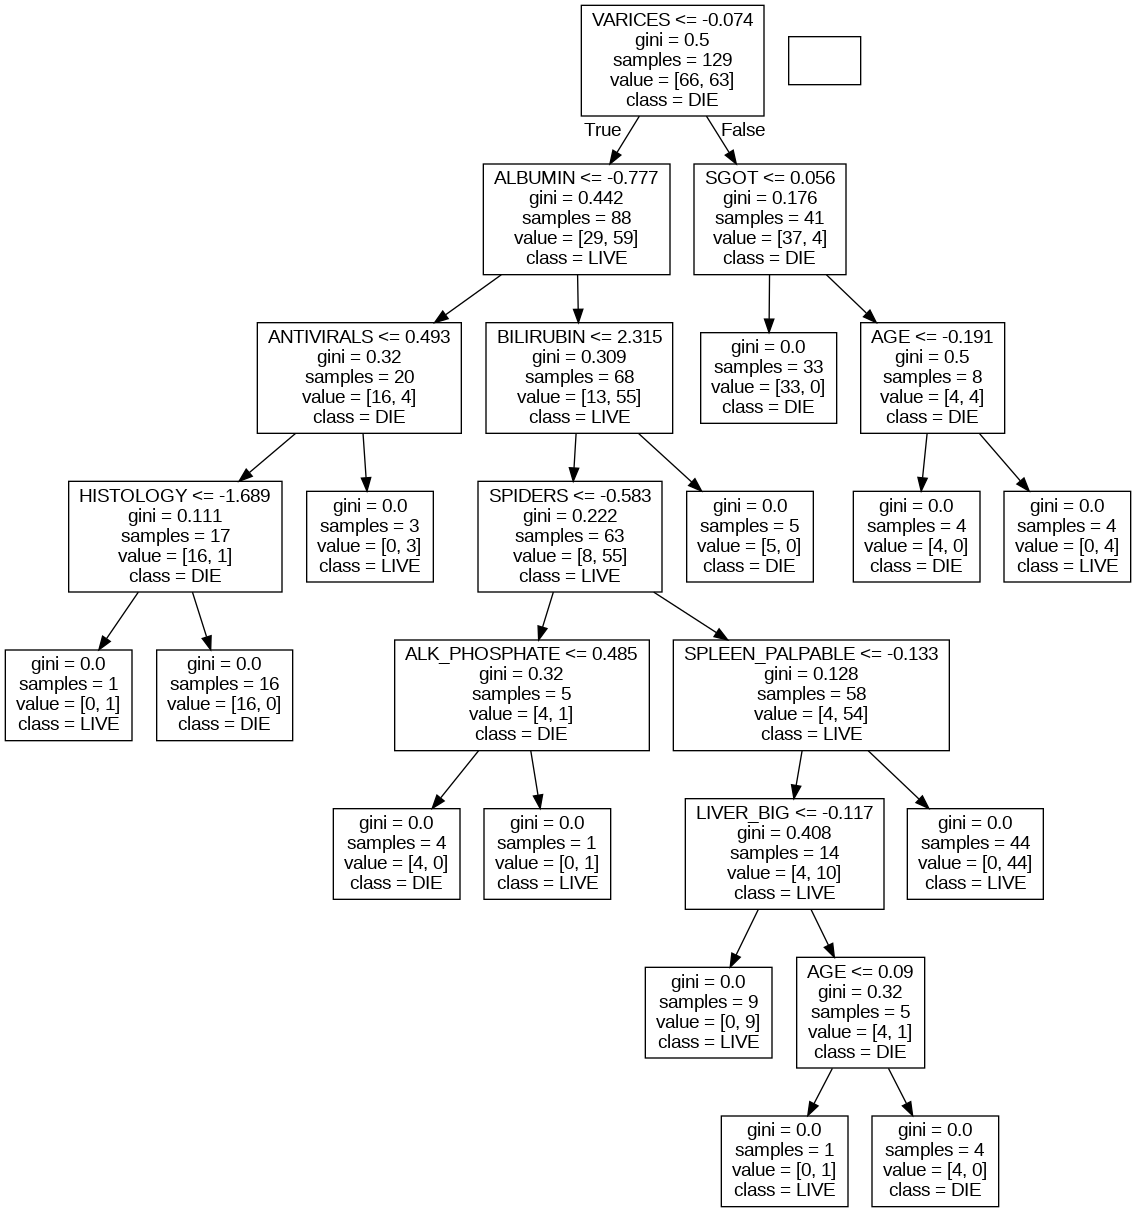

In [94]:
Image(graph.create_png())

# Exploratory Data Analysis (EDA)


In [ ]:
df.describe()

,AGE,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER BIG,LIVER FIRM,SPLEEN PALPABLE,SPIDERS,ASCITES,VARICES,BILIRUBIN,ALK PHOSPHATE,SGOT,ALBUMIN,PROTIME,HISTOLOGY
count,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000
mean,41.617647,1.509804,1.852941,1.372549,1.637255,1.823529,1.813725,1.607843,1.764706,1.666667,1.872549,1.872549,1.439216,101.813725,79.588235,3.829412,62.186275,1.500000
std,11.796999,0.502373,0.355914,0.485871,0.483166,0.383103,0.391251,0.490642,0.426277,0.473732,0.335124,0.335124,1.307265,44.671237,66.811743,0.593794,16.531237,0.502469
min,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.300000,30.000000,14.000000,2.100000,0.000000,1.000000
25%,34.000000,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,1.000000,2.000000,1.000000,2.000000,2.000000,0.800000,78.500000,30.250000,3.525000,58.500000,1.000000
50%,41.500000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,85.000000,55.000000,4.000000,62.000000,1.500000
75%,50.750000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.500000,122.250000,107.750000,4.175000,63.000000,2.000000
max,69.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,8.000000,256.000000,278.000000,5.300000,100.000000,2.000000


In [ ]:
df['Class'].value_counts()

DIE     81
LIVE    81
Name: Class, dtype: int64

<Axes: >

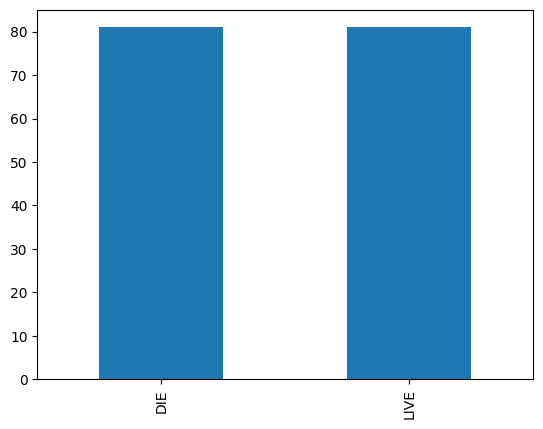

In [ ]:
# plot the graph
df['Class'].value_counts().plot(kind='bar')

In [ ]:
df.groupby(['AGE','SEX']).size()

AGE  SEX
7    M       1
20   M       1
22   F       1
23   M       4
24   M       1
25   M       1
27   M       3
28   M       3
30   F       1
     M       9
31   M       6
32   M       1
33   M       1
34   F       2
     M       6
35   M       1
36   M       4
37   M       3
38   M       5
39   M       4
40   M       3
41   M       1
42   M       8
43   M       5
44   M      11
45   F       1
     M       3
46   M       6
47   M       9
48   M       5
49   M       2
50   F       1
     M      10
51   M       9
52   M       3
53   F       1
54   M       5
56   M       7
58   M       1
59   M       1
60   M       1
61   M       7
62   F       1
65   M       1
67   F       1
69   F       1
dtype: int64

#### Our Observation

There is not much insight drawn , so will use frequency distribution

 #### Frequency Distribution Table

In [ ]:
labels = ['less than 10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70 and above']
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80]

freq_dis = df.groupby(pd.cut(df['AGE'], bins=bins, labels=labels, include_lowest=True)).size()

In [ ]:
freq_dis.index

CategoricalIndex(['less than 10', '10-20', '20-30', '30-40', '40-50', '50-60',
                  '60-70', '70 and above'],
                 categories=['less than 10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70 and above'], ordered=True, dtype='category', name='AGE')

In [ ]:
freq_dis

AGE
less than 10     1
10-20            1
20-30           23
30-40           36
40-50           62
50-60           28
60-70           11
70 and above     0
dtype: int64

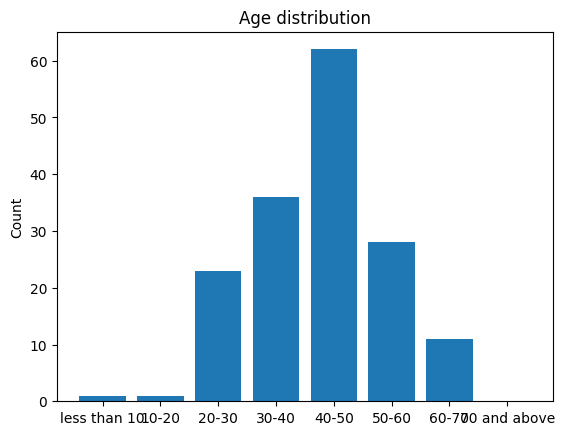

In [ ]:
plt.bar(freq_dis.index, freq_dis.values)
plt.ylabel('Count')
plt.title('Age distribution')
plt.show()

#### Our Observation
The most infected with hepatitis is between the age 20 to 60 years
The highest prevalence of Hepatitis occurs between the age of 40 to 50 years

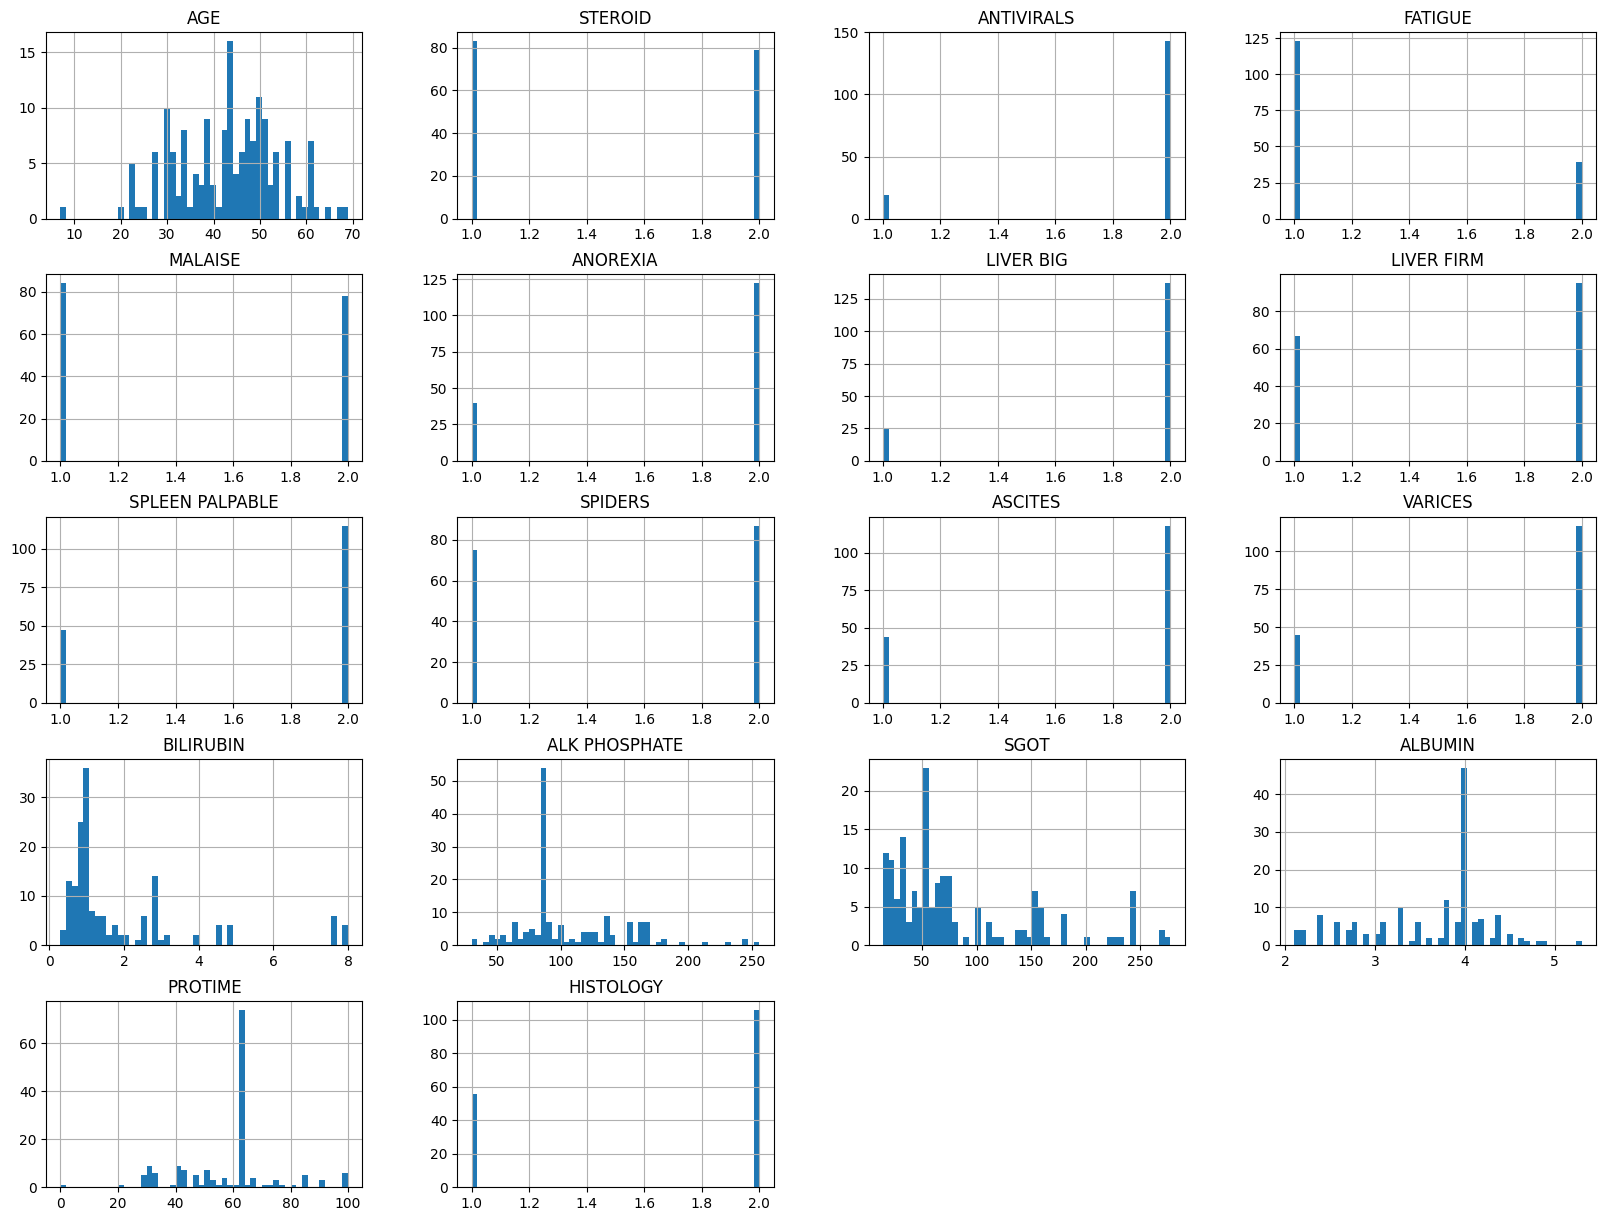

In [ ]:
# distribution of data
df.hist(bins=50,figsize=(20,15))
plt.show()

<Axes: xlabel='ALBUMIN', ylabel='AGE'>

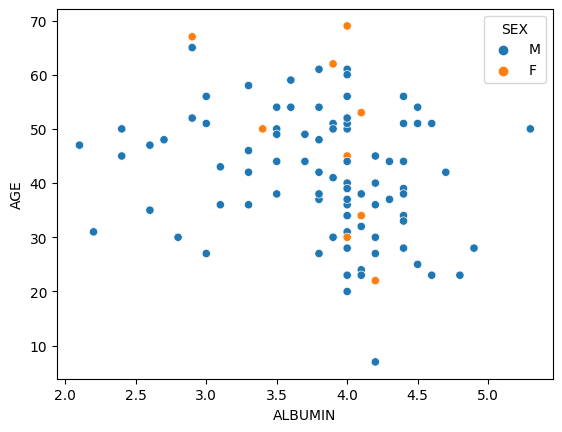

In [ ]:
sns.scatterplot(x=df['ALBUMIN'], y=df['AGE'], hue=df['SEX'], data=df)

Eli5 Explanation

In [ ]:
eli5.show_weights(gs,top=10)